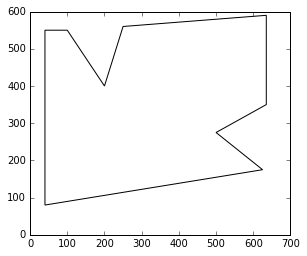

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
plt.axis("equal")
fig_size = [10,10]
plt.rcParams["figure.figsize"] = fig_size

data =np.array([[40, 50],
       [40, 520],
       [625,425],
       [500,325],
       [635,250],
       [635,10],
       [250,40],
       [200,200],
       [100,50]])
data[:,1] = data[:,1] *-1 + 600

plt.axes()
poly = plt.Polygon(data,fill=None,edgecolor="k",closed=True)
plt.gca().add_patch(poly)
#plt.plot(data[:,0],-data[:,1])
plt.axis('scaled')
plt.show()

In [2]:
from shapeanalyzer.vectmat import Vector2
from shapeanalyzer.shapes import Point, LineSegment, Ray, Polygon, Line

def bisector(po, p1, p2):
    v1 = Vector2(p1.x-po.x, p1.y-po.y).normalize()
    v2 = Vector2(p2.x-po.x, p2.y-po.y).normalize()
    bv = v1+v2
    return Ray(po,bv.normalize())

p0 = Point(0,0)
p1 = Point(1,0)
p2 = Point(0,1)
p3 = Point(1,1)
ray1 = bisector(p0,p1,p2)
ray2 = bisector(p2,p0,p3)
print ray1, ray2
rint = ray1.intersection(ray2)
print rint


Ray (Point ( 0.0, 0.0 ), Vector2 (0.71, 0.71)) Ray (Point ( 0.0, 1.0 ), Vector2 (0.71, -0.71))
Point ( 0.5, 0.5 )


In [3]:
points = []
for d in data:
    p = Point(d[0],d[1])
    points.append(p)

N = len(points)
for i in range(N):
    ppi = (i-2 + N) % N
    pi = (i-1 + N) % N
    ni = (i+1 + N) % N
    nni = (i+2 + N) % N
    pprev = points[ppi]
    prev = points[pi]
    curr = points[i]
    next = points[ni]
    nnext = points[nni]
    cray = bisector(curr, prev, next)
    pray = bisector(prev, pprev, curr)
    nray = bisector(next, curr, nnext)

Ray (Point ( 215.212435023, 134.266868414 ), Vector2 (0.99, -0.11))
Ray (Point ( 215.28637936, 134.258667288 ), Vector2 (0.96, -0.29))
Ray (Point ( 216.199423651, 134.066482764 ), Vector2 (-0.61, 0.79))
Ray (Point ( 216.197227797, 134.069360154 ), Vector2 (-0.79, 0.61))
Ray (Point ( 216.147681363, 134.10741949 ), Vector2 (-0.97, 0.24))
Ray (Point ( 215.465471463, 134.204234207 ), Vector2 (1.00, -0.07))
Ray (Point ( 216.014130901, 134.140711759 ), Vector2 (-1.00, 0.03))
Ray (Point ( 215.644572527, 134.192187759 ), Vector2 (0.98, -0.21))
Ray (Point ( 215.865449927, 134.145347561 ), Vector2 (-1.00, 0.03))
Ray (Point ( 215.865449927, 134.145347561 ), Vector2 (0.98, -0.21))


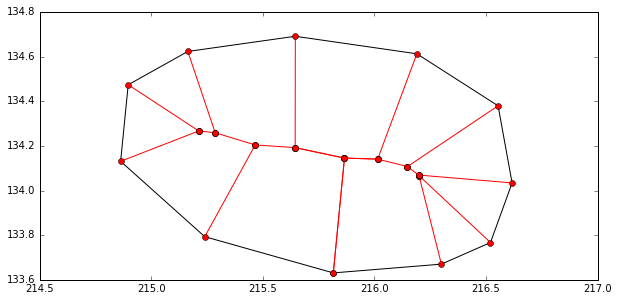

In [4]:
from shapeanalyzer.utilities import TinyQueue

fp = open("data/poly.csv")
lines = fp.readlines()
fp.close()
del lines[0]
data = []
points =[]
for l in lines:
    pid, x, y = l.strip().split(",")
    data.append([float(x), float(y)])
    points.append(Point(x,y))
    
data = np.asarray(data)
poly = Polygon(points)
class Vertex:
    def __init__(self, pt, pedge, nedge):
        self.pt = pt
        self.pedge = pedge
        self.nedge = nedge
        self.prev = None
        self.next = None
        self.is_reflex = self.pedge.vector().cross(self.nedge.vector()) < 0
        '''bisector vecotr'''
        bv = -self.pedge.vector().normalize() + self.nedge.vector().normalize() 
        self.bisector = Ray(self.pt,-bv.normalize()) if self.is_reflex else Ray(self.pt,bv.normalize())
        self.processed=False
        
class Event:
    def __init__(self, inter, Va, Vb, dis, etype):
        self.inter = inter
        self.Va = Va
        self.Vb = Vb
        self.dis = dis
        self.etype = etype
        
class LAV:
    def __init__(self):
        self.head = None
        self.len = 0
        
    def form_points(self, points):
        N = len(points)
        for i in range(N):
            pi = (i-1 + N) % N
            ni = (i+1 + N) % N
            ppt = points[pi]
            cpt = points[i]
            npt = points[ni]
            pedge = LineSegment(ppt, cpt)
            nedge = LineSegment(cpt, npt)
            vt = Vertex(cpt, pedge, nedge)
            if self.head is None:
                self.head = vt
                vt.prev = vt.next = vt
            else:
                vt.next = self.head
                vt.prev = self.head.prev
                vt.prev.next = vt
                self.head.prev = vt
                
    def __iter__(self):
        pos = self.head
        while True:
            yield pos
            pos = pos.next
            if pos == self.head:
                raise StopIteration

def vertbi_inter(v):
    b = v.bisector
    p = v.prev.bisector
    n = v.next.bisector
    print b
    pi = b.intersection(p)
    ni = b.intersection(n)
    pdis = v.pedge.height(pi) if pi else float("inf")
    ndis = v.nedge.height(ni) if ni else float("inf")
    if pdis == float("inf") and ndis == float("inf"):
        #print "all no inter"
        return None
    
    if pdis < ndis:
        evt = Event(pi, v.prev, v, pdis, 0)
        return evt
    else:
        evt = Event(ni, v, v.next, ndis, 0)
        return evt
    
lav = LAV()
lav.form_points(poly.points)
compare = lambda evt1, evt2: evt1.dis - evt2.dis
vQ = TinyQueue(compare=compare)
for v in lav:
    b = v.bisector
    p = v.prev.bisector
    n = v.next.bisector
    pi = b.intersection(p)
    ni = b.intersection(n)
    pdis = v.pedge.height(pi) if pi else float("inf")
    ndis = v.nedge.height(ni) if ni else float("inf")
    if pdis == float("inf") and ndis == float("inf"):
        #print "all no inter"
        continue
    #print v.pt, pdis, ndis
    if pdis < ndis:
        #plt.plot([v.pt.x, pi.x],[v.pt.y, pi.y],"-ro")
        evt = Event(pi, v.prev, v, pdis, 0)
        vQ.push(evt)
    else:
        #plt.plot([v.pt.x, ni.x],[v.pt.y, ni.y],"-ro")
        evt = Event(ni, v, v.next, ndis, 0)
        vQ.push(evt)

skes = []
while vQ.length:
    evt = vQ.pop()
    if evt.etype ==0:
        if evt.Va.processed and evt.Vb.processed:
            continue
        if evt.Va.prev.prev == evt.Vb:
            skes.append([evt.inter,evt.Va.prev.pt])
            
        ska = [evt.inter, evt.Va.pt]
        skb = [evt.inter, evt.Vb.pt]
        skes.append(ska)
        skes.append(skb)
        evt.Va.processed = True
        evt.Vb.processed = True
        
        nVet = Vertex(evt.inter, evt.Va.pedge, evt.Vb.nedge)
        evt.Va.prev.next = nVet
        evt.Vb.next.prev = nVet
        nVet.next = evt.Vb.next
        nVet.prev = evt.Va.prev
        nevt = vertbi_inter(nVet)
        if nevt:
            vQ.push(nevt)
for sk in skes:
    plt.plot([sk[0].x, sk[1].x],[sk[0].y, sk[1].y],"-ro")
        
plt.axes()
poly = plt.Polygon(data,fill=None,edgecolor="k",closed=True)
plt.gca().add_patch(poly)
#plt.plot(data[:,0],-data[:,1])
plt.axis('scaled')
plt.show()

In [15]:
def splited_at(Vt, lav):
    splits = TinyQueue(compare=lambda a, b: a["dis"] - b["dis"])
    for v in lav:
        edge = v.nedge
        pvedge = Vt.pedge
        nvedge = Vt.nedge
        bi = v.bisector
        bj = v.next.bisector
        l1 = Line(edge.fpt, edge.vector())
        l2 = Ray(Vt.pt, pvedge.vector())
        l3 = Ray(Vt.pt, -nvedge.vector())
        p0 = l1.intersection_ray(l2)
        p1 = l1.intersection_ray(l3)
        if p0 and p1:
            cpt = Point((p0.x+p1.x+Vt.pt.x)/3.0, (p0.y+p1.y+Vt.pt.y)/3.0)
            validB = limited_by(cpt, edge, bi, bj)
            if validB:
                #plt.plot(cpt.x, cpt.y,"ok")
                #plt.plot(p0.x, p0.y,"om")
                #plt.plot(p1.x,p1.y,"om")
                evt = {"B":cpt, "dis": edge.height(cpt),"Vt":Vt}
                splits.push(evt)
    sv = splits.pop()
    return sv["B"]

def line3_center(l1, l2, l3):
    p0 = l1.intersection(l2)
    p1 = l1.intersection(l3)
    p2 = l2.intersection(l3)
    if p0 and p1 and p2:
        return Point((p0.x+p1.x+p2.x)/3.0, (p0.y+p1.y+p2.y)/3.0)
    else:
        return None

def limited_by(pt, edge, bi, bj):
    tedge = edge.vector().cross(Vector2(pt.x - edge.fpt.x, pt.y - edge.fpt.y)) > 0
    tbi = bi.direction.cross(Vector2(pt.x - bi.origin.x, pt.y - bi.origin.y)) < 0
    tbj = bj.direction.cross(Vector2(pt.x - bj.origin.x, pt.y - bj.origin.y)) > 0
    return tedge and tbi and tbj

Point ( 272.818627451, 271.352941176 )
Point ( 226.690468854, 208.322953632 )


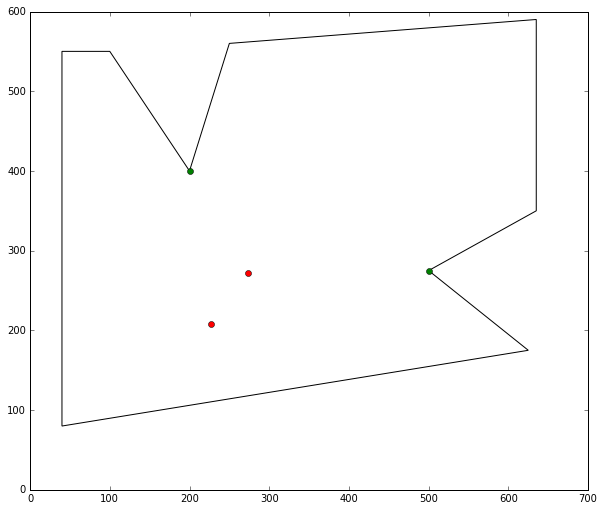

In [16]:
data =np.array([[40, 50],
       [40, 520],
       [625,425],
       [500,325],
       [635,250],
       [635,10],
       [250,40],
       [200,200],
       [100,50]])
data[:,1] = data[:,1] *-1 + 600
points = []
for d in data:
    points.append(Point(d[0], d[1]))
poly = Polygon(points)
lav = LAV()
lav.form_points(poly.points)
for v in lav:
    if v.is_reflex:
        plt.plot(v.pt.x, v.pt.y,"og")
        B = splited_at(v, lav)
        if B:
            print B
            plt.plot(B.x,B.y, "or")
plt.axes()
poly = plt.Polygon(data,fill=None,edgecolor="k",closed=True)
plt.gca().add_patch(poly)
#plt.plot(data[:,0],-data[:,1])
plt.axis('scaled')
plt.show()

In [17]:
slav = [lav]
